In [1]:
import os
import sys

root_directory = os.getcwd()[0:3]
sys.path.append(root_directory+'SCI\\SCI9\\2_DataAnalysis\\04_code\\1_04_Soybean')
sys.path.append(r'C:\ProgramData\anaconda3\Lib\site-packages') 
sys.path.append(r'C:\Users\DELL\.conda\envs\myenv\Lib\site-packages') 
sys.path.append(r'C:\Users\DELL\.conda\envs\rasterio_env\Lib\site-packages') 
import os
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from functions import prepare_and_model_data
from scipy.signal import savgol_filter
from scipy.stats import pearsonr

root_directory = os.getcwd()[0:3]
crop = '02_Wheat';
countryID ='06_India'
country =countryID[3:]
inputpath_base = root_directory + '\\SCI\\SCI9_1\\02_data\\'+crop+'\\'+countryID
inpath_dates_other = root_directory + '\\SCI\\SCI9_1\\02_data\\'+crop+'\\'+countryID+'\\'+'01_data'+'\\'+'07_Information'
other_infornamtion = pd.read_csv(os.path.join(inpath_dates_other,'information.txt'), sep=' ', header=None)
startyear,endyear,shp_name = other_infornamtion.iloc[0,0],other_infornamtion.iloc[0,1],other_infornamtion.iloc[0,2]


Forecastyear = endyear
years = range(startyear,endyear+1)
regions = ['I']
Forecastyears = {
    'I': endyear,
}

Cilmate = ['_Pre' ,'_Tmin' ,'_Solar','_Tmean','_Tmax']
Climate_Exogenous  = ['_CDD' ,'_HDD' ,'_GDD','_VPD','_wind_speed','_SPEI']
soil_feature = [ 'SAND','AWC', 'SILT','ORG_CARBON',  'TOTAL_N', 'PH_WATER',  'CEC_SOIL', 'CLAY']
loc_feature = ['elevation', 'lat', 'lon','Mean_Yield','Previous_Yield']
Year_feature = ['year'];union_feature = ['idJoin'];
static = soil_feature+loc_feature+Year_feature+union_feature+['Yield']


C:\Users\DELL\.conda\envs\myenv\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


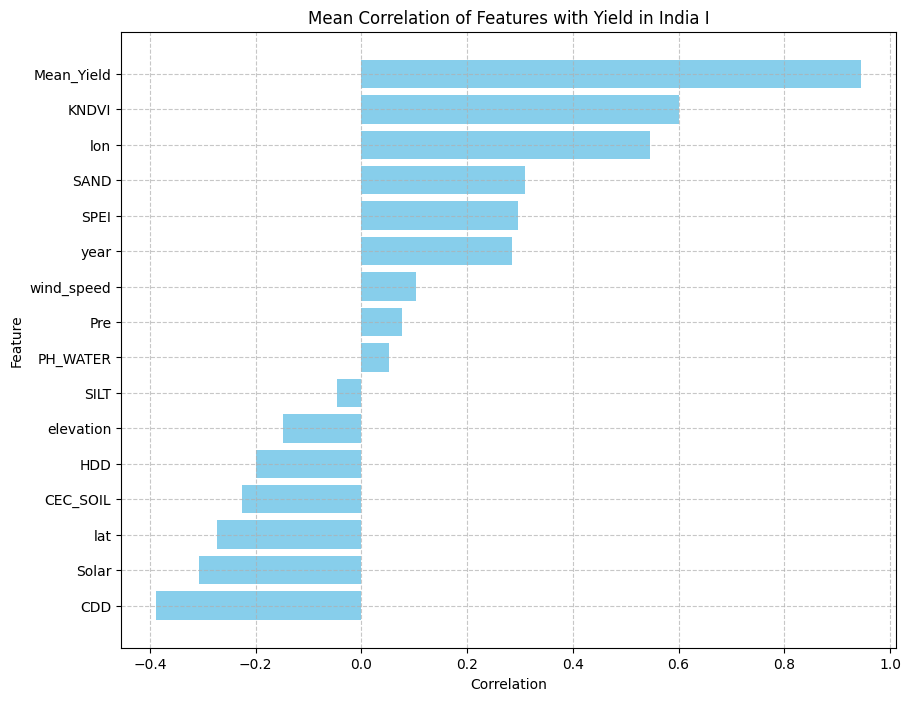

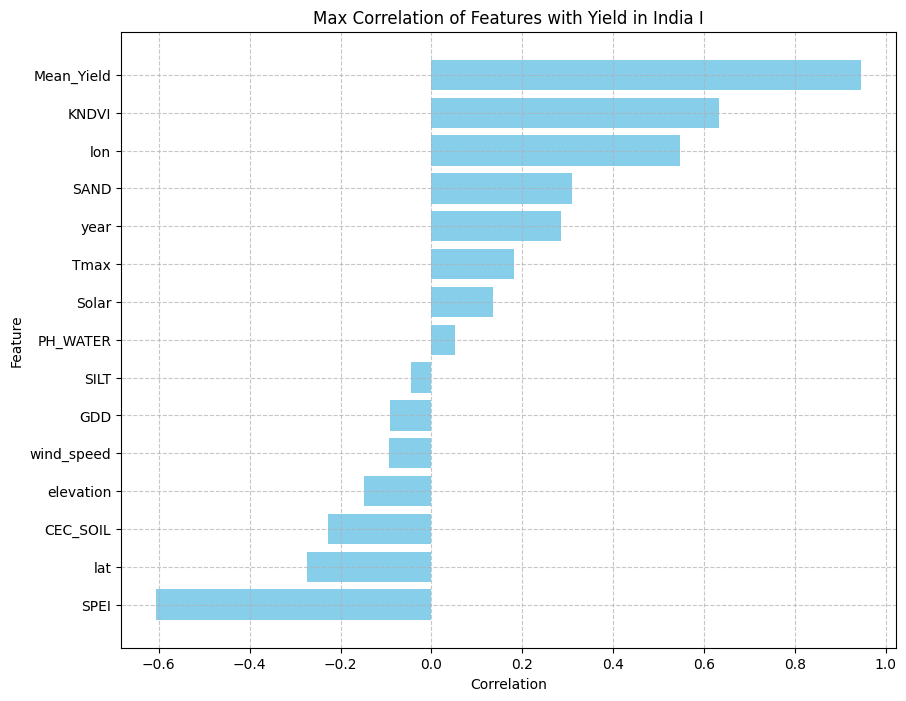

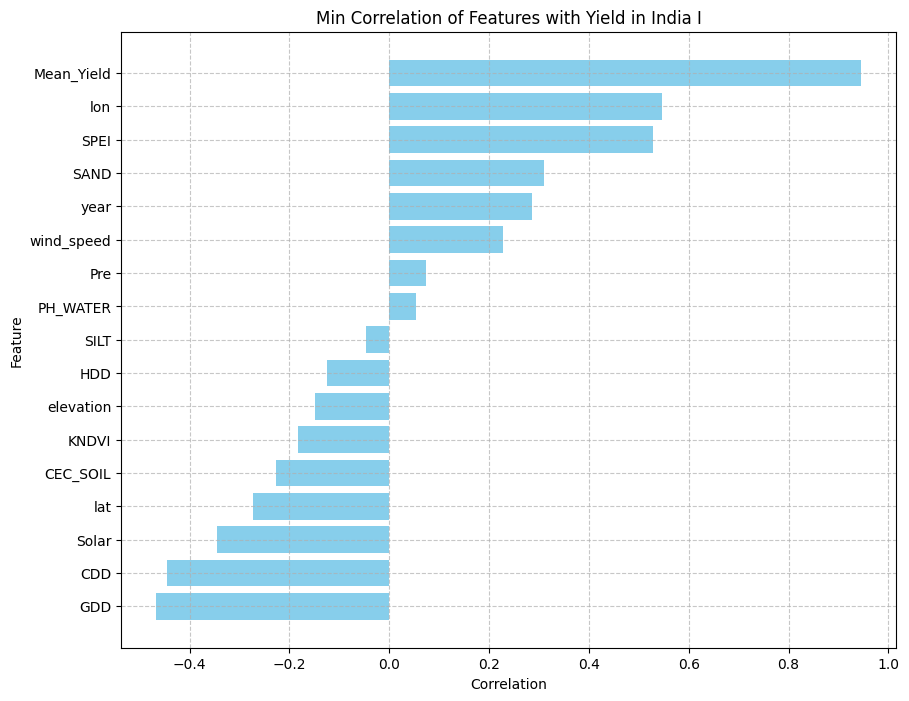

In [8]:
# [TODO] The threshold can be appropriately adjusted; for example, those passing the significance test can be retained

outpath_dates = os.path.join(inputpath_base, '01_data', '05_buildmodel', '04_selectFeatures', 'selectFeatures.txt')
# Ensure all directories in the path exist
os.makedirs(os.path.dirname(outpath_dates), exist_ok=True)

outpath_dates = os.path.join(inputpath_base, '01_data','05_buildmodel', '04_selectFeatures','selectFeatures.txt')
with open(outpath_dates, 'w') as file:
    pass  # Clear the file content


for region in regions[0:1]:
    # Filter and extract rows that meet the criteria
    inpath_dates = os.path.join(inputpath_base, '01_data','05_buildmodel', '02_extractdates','gs_three_periods.txt')
    gs_infornamtion = pd.read_csv(inpath_dates, delim_whitespace=True, header=None)
    gs_infornamtion.columns = ['start_point', 'peak', 'harvest_point', 'VI_select2','regionID']
    start_point, peak, harvest_point, VI_select2, region = gs_infornamtion[gs_infornamtion['regionID'] == region].iloc[0]
    
    inputpath_data = os.path.join(inputpath_base, '01_data','05_buildmodel', '01_weekdata',region+'_allweekYielddata_VIs.csv')
    data_yield_ori_Visall = pd.read_csv(inputpath_data)
    dataall_ori = prepare_and_model_data(startyear,start_point,harvest_point, data_yield_ori_Visall, VI_select2,static)
    
    ############################### Original data - Filter variables - Output results #####################################################

    
    ################################################ Mean value ##########################################################
    dynamic_features = [VI_select2]+Cilmate+Climate_Exogenous;
    static = soil_feature+loc_feature+Year_feature+union_feature+['Yield']
    
    mean_data = pd.DataFrame()
    for feature in dynamic_features:
        columns = [col for col in dataall_ori.columns if feature in col];
        mean_data[feature[1:]] = dataall_ori[columns].mean(axis=1)
    mean_data[static] = dataall_ori[static]

    data = mean_data.drop(['idJoin'], axis=1)

    # Initialize an empty DataFrame to store results
    results = pd.DataFrame(columns=['Variable', 'Correlation', 'P-value'])
    
    # Calculate correlation with 'Yield' for each variable
    for variable in data.columns[:-1]:  # Exclude the last column 'Yield'
        correlation, p_value = pearsonr(data[variable], data['Yield'])
        temp_df = pd.DataFrame({'Variable': [variable], 'Correlation': [correlation], 'P-value': [p_value]})
        results = pd.concat([results, temp_df], ignore_index=True)
    
    # Filter out significant variables
    significant_variables = results[results['P-value'] < 0.05]
    corrlist = significant_variables['Variable'].values
    
    
    # Remove high inter-factor correlations
    corr_matrix = mean_data[list(corrlist)+['Yield']].corr()
    high_corr_var = [(c1, c2) for c1 in corr_matrix.columns for c2 in corr_matrix.columns if (c1 != c2) and (corr_matrix.loc[c1, c2] > 0.8)]
    features_to_remove = set()
    for c1, c2 in high_corr_var:
        if c1 == 'Yield' or c2 == 'Yield' or c1 in features_to_remove or c2 in features_to_remove:
            continue
        features_to_remove.add(c1 if corr_matrix.loc[c1, 'Yield'] < corr_matrix.loc[c2, 'Yield'] else c2)
    
    corrlist= list(set(corrlist) - features_to_remove)
    
    filtered_columns = [col for col in dataall_ori.columns if any(feature in col for feature in corrlist)]
    
    
    filtered_data_ori = dataall_ori[filtered_columns+['Yield']]
    yield_columns = [col for col in filtered_columns if 'Yield' in col]
    
    TimeFeatures_sel1 = [x for x in corrlist if x not in static]
    Static_sel1 = [x for x in corrlist if x not in TimeFeatures_sel1]
    
    outputpath_figures = os.path.join(inputpath_base, '06_figure',f'Mean Correlation of Selected Features with Yield  in {country} {region}.jpg')
    corr = mean_data.drop(['idJoin'],axis=1)[TimeFeatures_sel1+Static_sel1+['Yield']].corr()['Yield'][:-1]
    df = pd.DataFrame(corr)
    df_sorted = df.sort_values(by='Yield')
    plt.figure(figsize=(10, 8))
    plt.barh(df_sorted.index.tolist(), df_sorted['Yield'], color='skyblue')
   # plt.axvline(x=0.15, color='red', linestyle='--', label='x=0.15')
   # plt.axvline(x=-0.15, color='red', linestyle='--', label='x=-0.15')
    plt.xlabel('Correlation')
    plt.ylabel('Feature')
    plt.title(f'Mean Correlation of Features with Yield in {country} {region}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(outputpath_figures)
    plt.show()
    
    ################################################ Maximum value ##########################################################
    dynamic_features = [VI_select2]+Cilmate+Climate_Exogenous;
    static = soil_feature+loc_feature+Year_feature+union_feature+['Yield']
    
    mean_data = pd.DataFrame()
    for feature in dynamic_features:
        columns = [col for col in dataall_ori.columns if feature in col];
        mean_data[feature[1:]] = dataall_ori[columns].max(axis=1)
    mean_data[static] = dataall_ori[static]

    data = mean_data.drop(['idJoin'], axis=1)

    # Initialize an empty DataFrame to store results
    results = pd.DataFrame(columns=['Variable', 'Correlation', 'P-value'])
    
    # Calculate correlation with 'Yield' for each variable
    for variable in data.columns[:-1]:  # Exclude the last column 'Yield'
        correlation, p_value = pearsonr(data[variable], data['Yield'])
        temp_df = pd.DataFrame({'Variable': [variable], 'Correlation': [correlation], 'P-value': [p_value]})
        results = pd.concat([results, temp_df], ignore_index=True)
    
    # Filter out significant variables
    significant_variables = results[results['P-value'] < 0.05]
    corrlist = significant_variables['Variable'].values
    
    
    # Remove high inter-factor correlations
    corr_matrix = mean_data[list(corrlist)+['Yield']].corr()
    high_corr_var = [(c1, c2) for c1 in corr_matrix.columns for c2 in corr_matrix.columns if (c1 != c2) and (corr_matrix.loc[c1, c2] > 0.8)]
    features_to_remove = set()
    for c1, c2 in high_corr_var:
        if c1 == 'Yield' or c2 == 'Yield' or c1 in features_to_remove or c2 in features_to_remove:
            continue
        features_to_remove.add(c1 if corr_matrix.loc[c1, 'Yield'] < corr_matrix.loc[c2, 'Yield'] else c2)
    
    corrlist= list(set(corrlist) - features_to_remove)
    
    filtered_columns = [col for col in dataall_ori.columns if any(feature in col for feature in corrlist)]
    
    
    filtered_data_ori = dataall_ori[filtered_columns+['Yield']]
    yield_columns = [col for col in filtered_columns if 'Yield' in col]
    
    TimeFeatures_sel2 = [x for x in corrlist if x not in static]
    Static_sel2 = [x for x in corrlist if x not in TimeFeatures_sel2]
    
    outputpath_figures = os.path.join(inputpath_base, '06_figure',f'Max Correlation of Selected Features with Yield  in {country} {region}.jpg')
    corr = mean_data.drop(['idJoin'],axis=1)[TimeFeatures_sel2+Static_sel2+['Yield']].corr()['Yield'][:-1]
    df = pd.DataFrame(corr)
    df_sorted = df.sort_values(by='Yield')
    plt.figure(figsize=(10, 8))
    plt.barh(df_sorted.index.tolist(), df_sorted['Yield'], color='skyblue')
   # plt.axvline(x=0.15, color='red', linestyle='--', label='x=0.15')
   # plt.axvline(x=-0.15, color='red', linestyle='--', label='x=-0.15')
    plt.xlabel('Correlation')
    plt.ylabel('Feature')
    plt.title(f'Max Correlation of Features with Yield in {country} {region}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(outputpath_figures)
    plt.show()
    
    ################################################ Minimum value ##########################################################
    dynamic_features = [VI_select2]+Cilmate+Climate_Exogenous;
    static = soil_feature+loc_feature+Year_feature+union_feature+['Yield']
    
    mean_data = pd.DataFrame()
    for feature in dynamic_features:
        columns = [col for col in dataall_ori.columns if feature in col];
        mean_data[feature[1:]] = dataall_ori[columns].min(axis=1)
    mean_data[static] = dataall_ori[static]

    data = mean_data.drop(['idJoin'], axis=1)

    # Initialize an empty DataFrame to store results
    results = pd.DataFrame(columns=['Variable', 'Correlation', 'P-value'])
    
    # Calculate correlation with 'Yield' for each variable
    for variable in data.columns[:-1]:  # Exclude the last column 'Yield'
        correlation, p_value = pearsonr(data[variable], data['Yield'])
        temp_df = pd.DataFrame({'Variable': [variable], 'Correlation': [correlation], 'P-value': [p_value]})
        results = pd.concat([results, temp_df], ignore_index=True)
    
    # Filter out significant variables
    significant_variables = results[results['P-value'] < 0.05]
    corrlist = significant_variables['Variable'].values
    
    
    # Remove high inter-factor correlations
    corr_matrix = mean_data[list(corrlist)+['Yield']].corr()
    high_corr_var = [(c1, c2) for c1 in corr_matrix.columns for c2 in corr_matrix.columns if (c1 != c2) and (corr_matrix.loc[c1, c2] > 0.8)]
    features_to_remove = set()
    for c1, c2 in high_corr_var:
        if c1 == 'Yield' or c2 == 'Yield' or c1 in features_to_remove or c2 in features_to_remove:
            continue
        features_to_remove.add(c1 if corr_matrix.loc[c1, 'Yield'] < corr_matrix.loc[c2, 'Yield'] else c2)
    
    corrlist= list(set(corrlist) - features_to_remove)
    
    filtered_columns = [col for col in dataall_ori.columns if any(feature in col for feature in corrlist)]
    
    
    filtered_data_ori = dataall_ori[filtered_columns+['Yield']]
    yield_columns = [col for col in filtered_columns if 'Yield' in col]
    
    TimeFeatures_sel3 = [x for x in corrlist if x not in static]
    Static_sel3 = [x for x in corrlist if x not in TimeFeatures_sel3]
    
    outputpath_figures = os.path.join(inputpath_base, '06_figure',f'Min Correlation of Selected Features with Yield  in {country} {region}.jpg')
    corr = mean_data.drop(['idJoin'],axis=1)[TimeFeatures_sel3+Static_sel3+['Yield']].corr()['Yield'][:-1]
    df = pd.DataFrame(corr)
    df_sorted = df.sort_values(by='Yield')
    plt.figure(figsize=(10, 8))
    plt.barh(df_sorted.index.tolist(), df_sorted['Yield'], color='skyblue')
   # plt.axvline(x=0.15, color='red', linestyle='--', label='x=0.15')
   # plt.axvline(x=-0.15, color='red', linestyle='--', label='x=-0.15')
    plt.xlabel('Correlation')
    plt.ylabel('Feature')
    plt.title(f'Min Correlation of Features with Yield in {country} {region}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(outputpath_figures)
    plt.show()    
    ####################################### Take the union of the three sets ##########################################################
    TimeFeatures_sel = list(set(TimeFeatures_sel1).union(TimeFeatures_sel2, TimeFeatures_sel3))
    Static_sel = list(set(Static_sel1).union(Static_sel2, Static_sel3))

   
    #################################################### Yield without trend removal and annual variation trends of selected time series #############################################
    # Create figure and first axis
    
    '''
    for feature in TimeFeatures_sel + yield_columns:
        fig, ax1 = plt.subplots(figsize=(12, 6))
        sns.boxplot(x='year', y=feature, data=mean_data, ax=ax1, color='lightblue', showfliers=False)
        ax1.set_ylabel(f'{feature} Value')
        ax1.set_title(f'Yearly Distribution of {feature} and Yield')
        ax1.grid(True)
        
        ax2 = ax1.twinx()
        sns.boxplot(x='year', y='Yield', data=mean_data, ax=ax2, color='lightgreen', showfliers=False)
        ax2.set_ylabel('Yield Value')
        ax1.legend([feature], loc='upper left')
        ax2.legend(['Yield'], loc='upper right')
        outpath_fig2 = os.path.join(inputpath_base, '06_figure', f'{feature} and Yearly Distribution in {country} {region}.jpg')
        plt.savefig(outpath_fig2)
        plt.show()
    '''

    
    if VI_select2[1:] not in TimeFeatures_sel:
        TimeFeatures_sel.append(VI_select2[1:])


    if 'year' not in Static_sel:
        Static_sel.append('year')
        # Still use the original setting
    # TimeFeatures_sel = TimeFeatures_sel1;Static_sel=Static_sel1    
    filtered_columns = [col for col in dataall_ori.columns if any(feature in col for feature in TimeFeatures_sel+Static_sel)]
    filtered_data_ori = dataall_ori[filtered_columns+['idJoin','Yield']+['year']]
    os.makedirs(os.path.join(inputpath_base, '01_data','05_buildmodel','03_modeldata'), exist_ok=True)
    filtered_data_ori = filtered_data_ori.rename(columns={'Yield': 'actual_yield'}) 
    filtered_data_ori.to_csv(os.path.join(inputpath_base, '01_data','05_buildmodel','03_modeldata',f'{region}_data_ori.csv'), index=False)
    os.makedirs(os.path.join(inputpath_base, '01_data','05_buildmodel','04_selectFeatures'), exist_ok=True)

    with open(outpath_dates, 'a') as file:
        file.write(f'{TimeFeatures_sel}\t{Static_sel}\t{region}\n')

In [5]:
# 之前只是mean，现在想加上max和min；只要有一个被筛选进去，就保留哈
TimeFeatures_sel

['CDD', 'Pre', 'wind_speed', 'KNDVI', 'VPD', 'GDD', 'HDD', 'SPEI', 'Solar']

In [7]:
Static_sel

['Mean_Yield',
 'SILT',
 'elevation',
 'lat',
 'lon',
 'year',
 'SAND',
 'CEC_SOIL',
 'PH_WATER']

In [10]:
Static_sel


['TOTAL_N',
 'SAND',
 'lon',
 'Mean_Yield',
 'year',
 'SILT',
 'elevation',
 'lat',
 'AWC',
 'PH_WATER']

In [14]:

TimeFeatures_sel

['Solar', 'KNDVI', 'HDD', 'Pre', 'Tmax', 'GDD', 'SPEI', 'wind_speed']

['Mean_Yield', 'Previous_Yield']